This notebook is the exact same as test_ttvnest, but here we're going to be testing multiprocessing.

In this tutorial, we're going to attempt to estimate the mass of the planets in the Kepler-29 system from TTVs, comparing to the results of Jontof-Hutter et al. (2016). From Table 4, Test 3 of that paper (which also uses the Holczer catalog), we're looking for a dynamical masses of 3.3(+1.8)(-1.7) and 2.6(+1.4)(-1.3), respectively (where the error bars represent 1sigma credible intervals).

First, we'll set everything up and import ttvnest:

In [2]:
%matplotlib inline
import numpy as np
import ttvnest
import scipy
import time
import multiprocess

Now, let's download the data for Kepler-29 (KOI-738) from the Holczer et al. (2016) catalog:

In [2]:
koi = 738
nplanets = 2
data, errs = ttvnest.load_data.get_data(koi, nplanets)

Data retrieved!


Next, we need to define the prior transform. Nested sampling methods typically sample on the unit cube (from 0 to 1 in all dimensions), so we need a way to map that into our preferred prior space. Eventually, I'll try to abstract the prior transform away from the user.

In [3]:
#defining the prior transform

def prior_transform(u):
	x = np.array(u) #copy u
	#planet 1
	x[0] = 10.*u[0] #uniform on [0, 10) earth masses
	x[1] = scipy.stats.norm.ppf(u[1], 10.33585, 0.01)  #gaussian around 10.33585 with a width of 0.01
	x[2] = scipy.stats.norm.ppf(u[2], 0, 0.1) #gaussian around 0 with a width of 0.1
	x[3] = scipy.stats.norm.ppf(u[3], 0, 0.1) #gaussian around 0 with a width of 0.1
	x[4] = (u[4] % 1.) * 360. #periodic on [0, 360) degrees
	#planet 2
	x[5] = 10.*u[5] #uniform on [0, 10) earth masses
	x[6] = scipy.stats.norm.ppf(u[6], 13.29292, 0.01) #gaussian around 13.29292 with a width of 0.01
	x[7] = scipy.stats.norm.ppf(u[7], 0, 0.1) #gaussian around 0 with a width of 0.1
	x[8] = scipy.stats.norm.ppf(u[8], 0, 0.1) #gaussian around 0 with a width of 0.1
	x[9] = (u[9] % 1.) * 360. #periodic on [0, 360) degrees
	return x

Finally, we sample the posteriors!

In [4]:
with Pool(4) as executor:
    %time results = ttvnest.retrieval.retrieve(nplanets, prior_transform, data, errs, pool = executor, queue_size = 4)

Running dynesty with the rwalk sampler and multi bounding...


iter: 10482 | batch: 0 | bound: 56 | nc: 25 | ncall: 216901 | eff(%):  4.810 | loglstar:   -inf < -36408.674 <    inf | logz: -36426.751 +/-    nan | dlogz: 28081.288 >  0.010                       /usr/local/lib/python3.7/site-packages/dynesty/sampling.py:237: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
iter: 11270 | batch: 0 | bound: 63 | nc: 25 | ncall: 241435 | eff(%):  4.649 | loglstar:   -inf < -29467.169 <    inf | logz: -29486.004 +/-    nan | dlogz: 24962.003 >  0.010                       /usr/local/lib/python3.7/site-packages/dynesty/sampling.py:237: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
iter: 16766 | batch: 0 | bound: 108 | nc: 25 | ncall: 405320 | eff(%):  4.126 | loglstar:   -inf < -7949.289 <    inf | logz: -7973.250 +/-    nan

CPU times: user 10min 8s, sys: 59.7 s, total: 11min 7s
Wall time: 7h 23min 38s


Let's now see a summary of our results:

In [5]:
ttvnest.retrieval.posterior_summary(results)

Summary: 
$M_1/M_\star$: $3.7230992582677054^{+1.416363402784671}_{-1.2597173718173824}$
$P_1\ [\mathrm{days}]$: $10.335930651663503^{+0.00027319516918566933}_{-0.0005538220044005726}$
$e_1\cos(\omega_1)$: $-0.050902520573424405^{+0.031261938308024886}_{-0.02501770759999388}$
$e_1\sin(\omega_1)$: $-0.12254141907140428^{+0.17878707734753552}_{-0.04017137613845145}$
$\mathcal{M}_1\ [^\circ]$: $207.12874799235007^{+10.177814176863222}_{-18.433604384448955}$
$M_2/M_\star$: $3.150144131980336^{+1.1707801457421532}_{-1.0287773792265318}$
$P_2\ [\mathrm{days}]$: $13.293335238214912^{+0.0013382088077094068}_{-0.000625610427960055}$
$e_2\cos(\omega_2)$: $-0.028085850670279106^{+0.027706872389100638}_{-0.0233112813221531}$
$e_2\sin(\omega_2)$: $-0.10030319288154142^{+0.136360539377808}_{-0.034392151419010294}$
$\mathcal{M}_2\ [^\circ]$: $234.48479913422204^{+10.081817206848115}_{-192.27457995267523}$


And let's plot the result, as well as the corner plot, a summary of the run, and the dynesty trace plot.

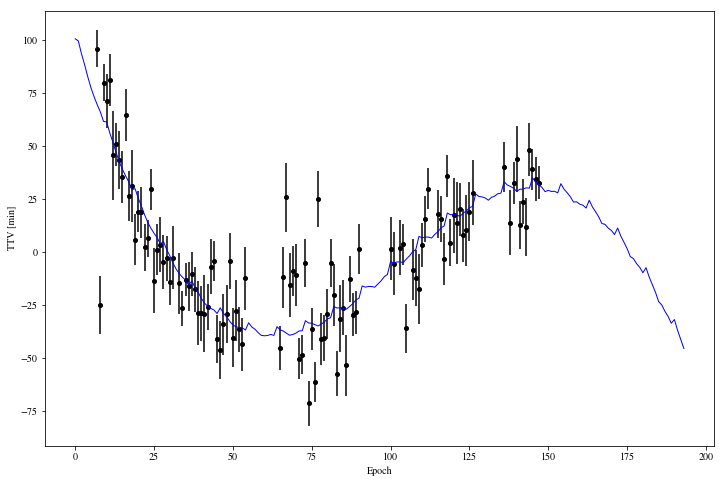

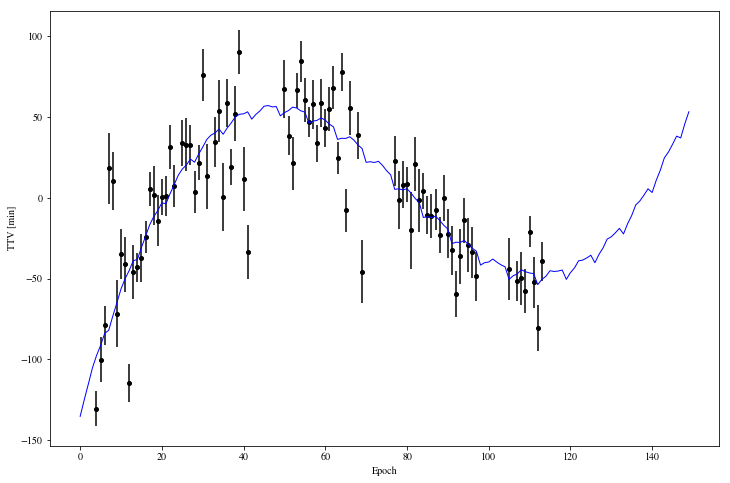

<Figure size 1440x1440 with 0 Axes>

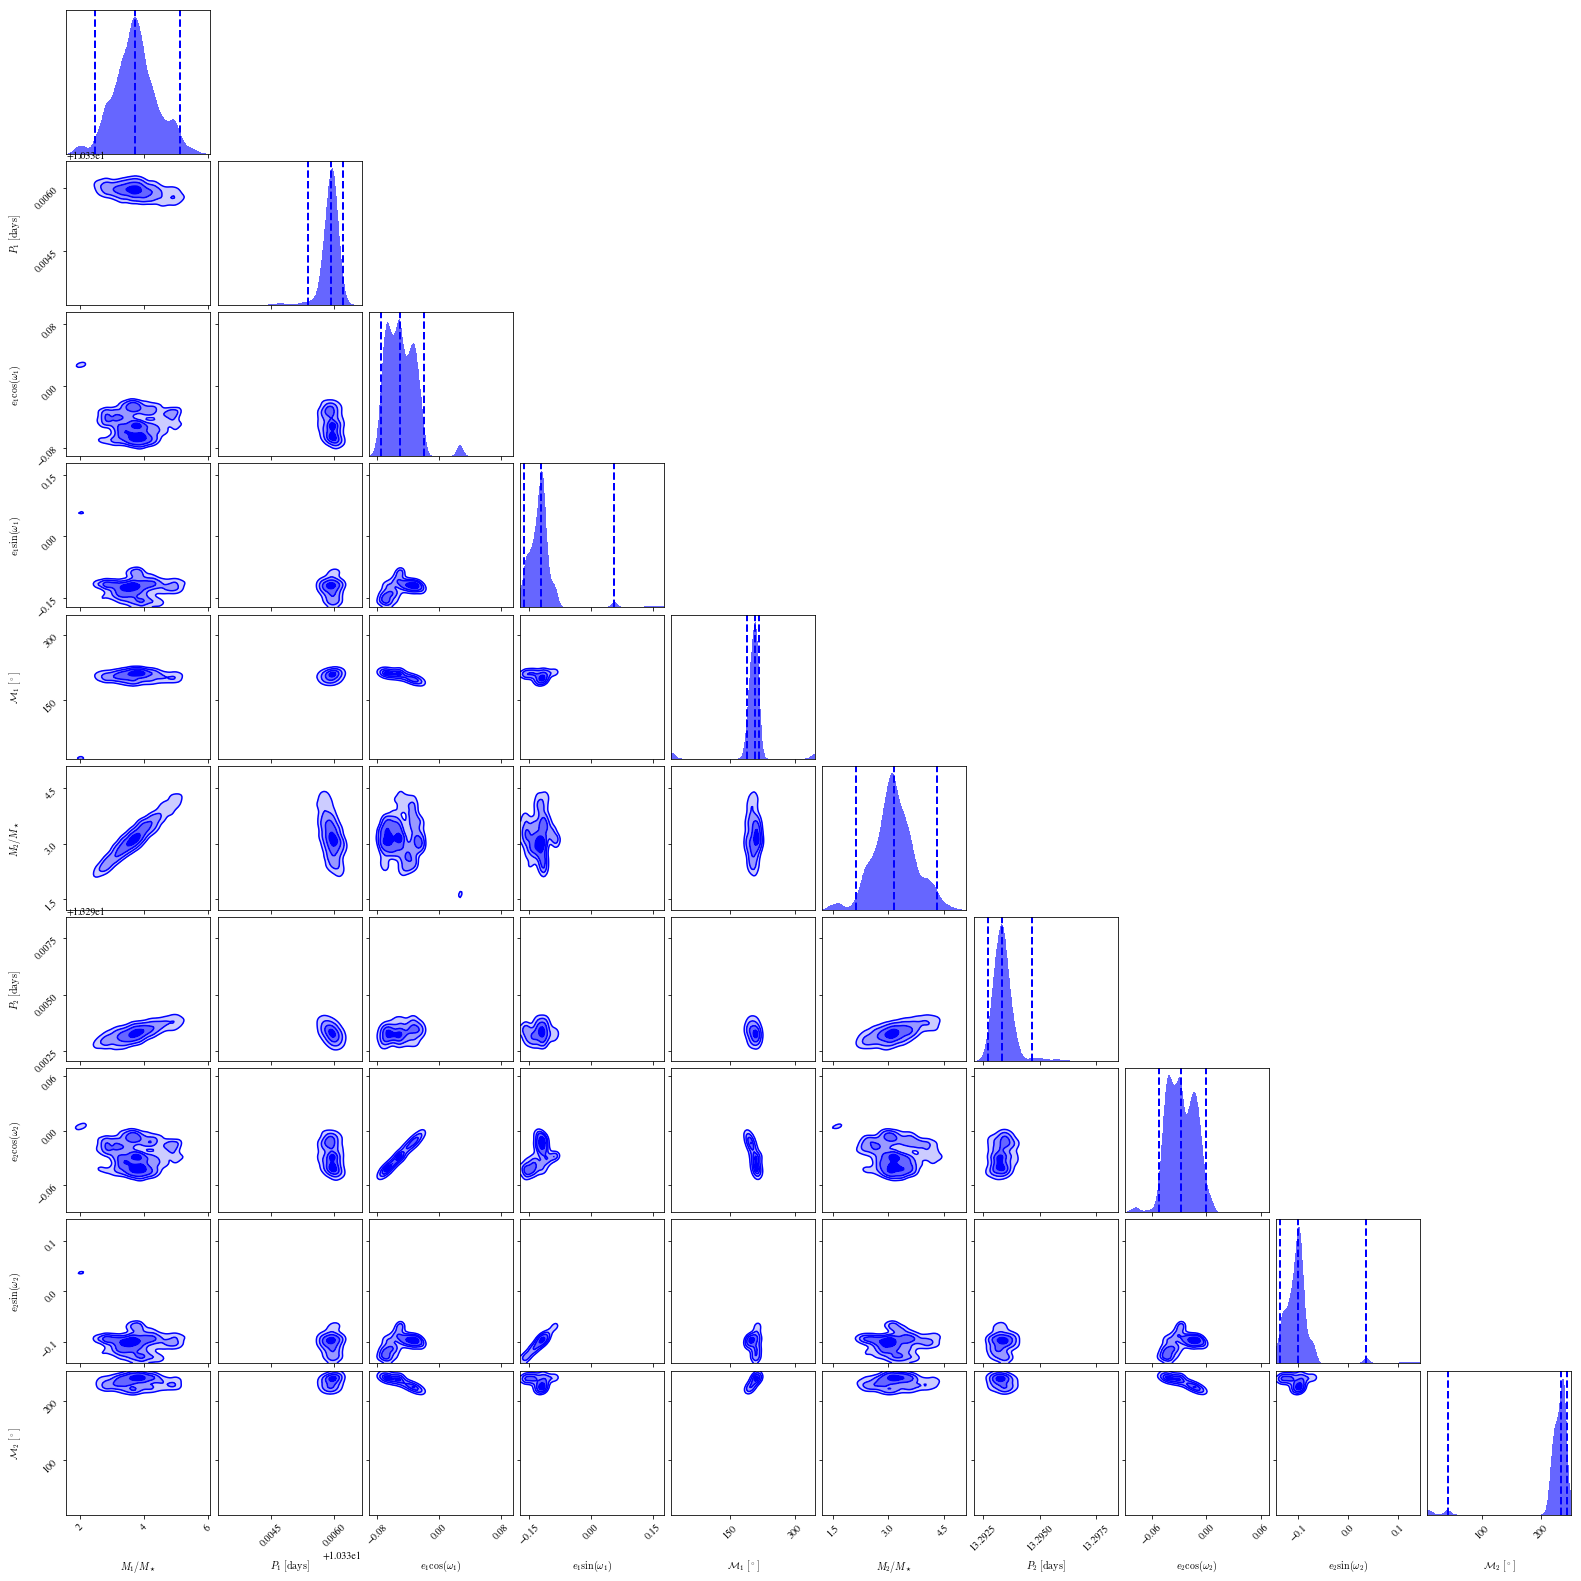

<Figure size 1440x1440 with 0 Axes>

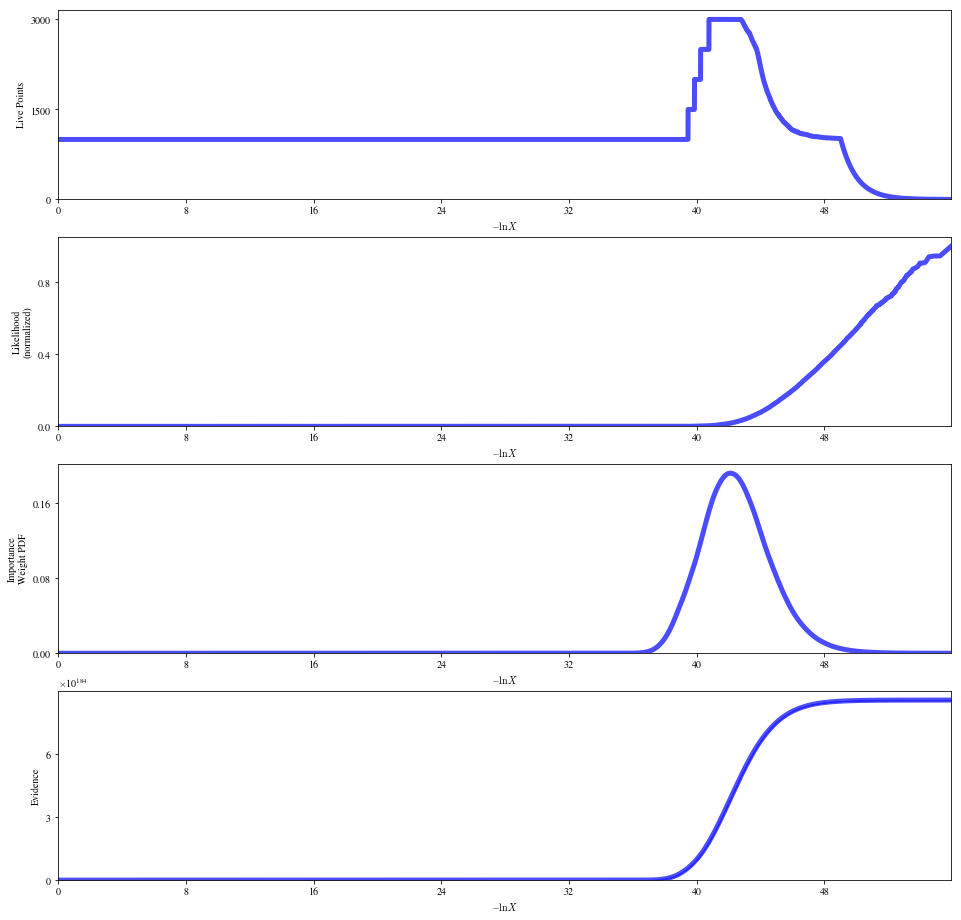

<Figure size 1440x1440 with 0 Axes>

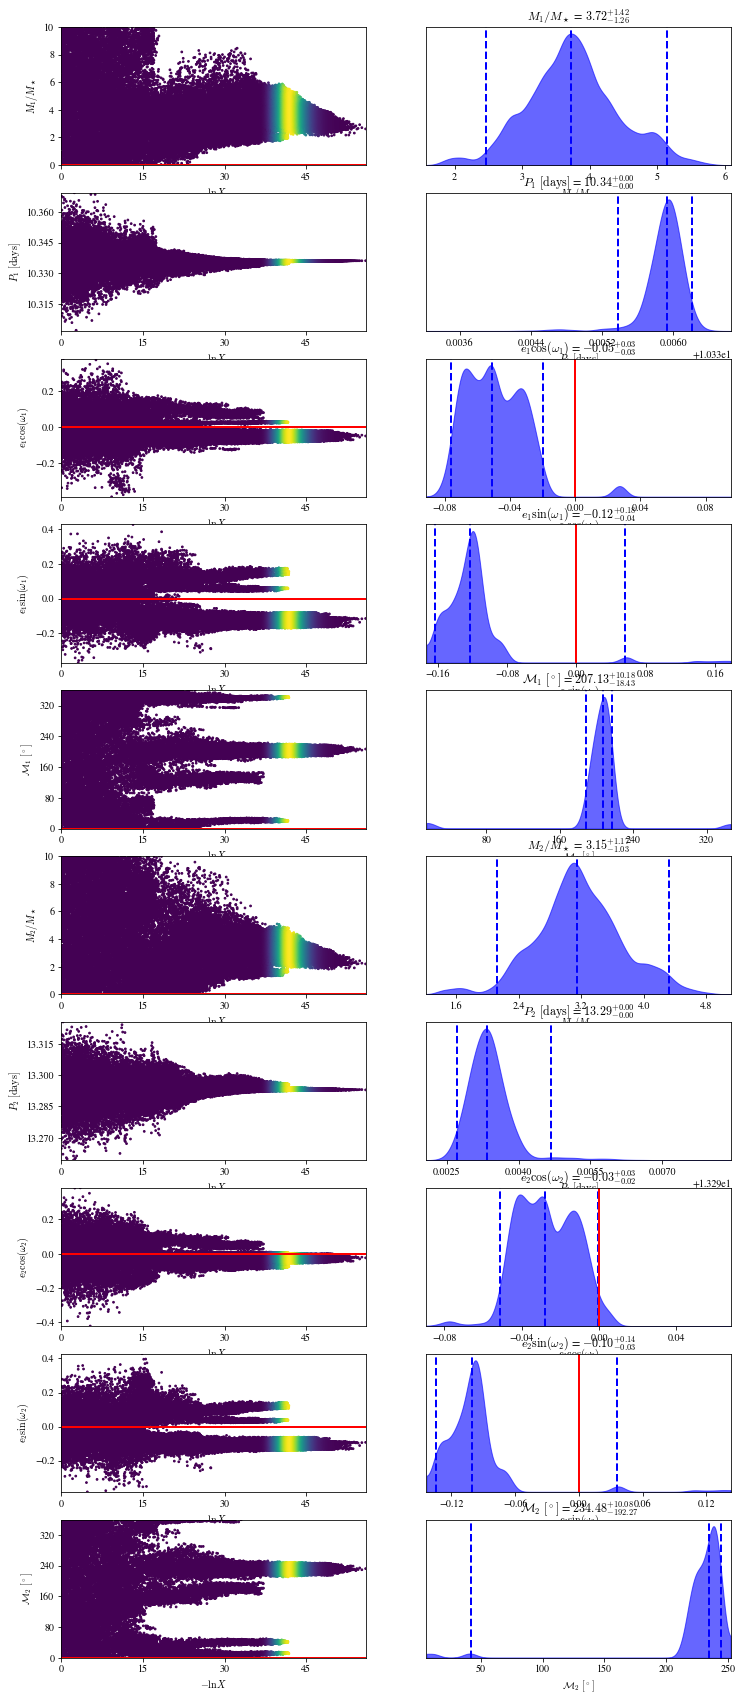

In [6]:
ttvnest.plot_utils.plot_results(results, data, errs)
ttvnest.plot_utils.dynesty_plots(results, nplanets)

Let's make sure to save our results! The results will be saved in a file called 'results.p' by default, but you can change that with the "outname" keyword for save_results.

In [7]:
ttvnest.io_utils.save_results(results, outname = 'results_kep29_thompson18times.p')

'results_kep29_thompson18times.p'